In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.style.use(['dark_background'])

After a conversation with Matt, I think I finally understand the concept of approximating (parameters of) a distribution using machine learning. (parameters he called location and scale)

**Distributions of interest**

- Continuous: Gaussian (log normal -just an exponentiated gaussian, take log of it and its a normal), exponential (special case of the gamma), beta, Pareto. He didn't mention chi squared or gamma but then they came up later (gamma is generalized chi squared and expontential - sum of independent exponential/chi-squared - wait time until you get k events is poisson as well)
- Discrete: binomial (Bernoulli - n=1), poisson,

**Support of a variable**

- "In probability theory, the support of a probability distribution can be loosely thought of as the closure of the set of possible values of a random variable having that distribution." - wikipedia
- basically, is random variable discrete (ints) or continuous (real numbers) and what are it's limits/bounds



**Goal of ML DS: Characterizing the dataset**

- understand the support
- Then look at shape of the density function (histogram). Typically piles up at zero and then long tail (exponential or Pareto). Fancy shit to check if it fits one or the other (but that's second order correction... You're 90% there already). Then try to fit the parameters of the distribution. So which log normal are we talking about well that's defined by it's parameters (what valu of location and scale parameters)

**Loss Function is an assumption of the distribution**

- Classification: Log likelihood of a Bernoulli distribution is the loss function used as it selects p such that when y is 1 p is high (and vice versa). Think about it, in binary classification, you're trying to approximate the parameter(s) of a Bernoulli distribution which there is only one of (i.e. the probability of the positive class). Thus the output of your model is an inference on the underlying distribution of that Bernoulli random variable whose parameter depends on where you are in the feature space. (eg p = 0.5 for a coin toss)
- Regression: RMSE assumes gaussian and returns expected value of the distribution (i.e. the mean). Given a point in the feature space...Assumes a gaussian distribution at that point in the feature space. It assumes that at any point in feature space the variance is constant (with rmse (residual variance) of model being a sample estimator this variance). And it estimates the expected value at each point in feature space 

**ML for distribution at specific loc in feature space**

- Machine learning estimates the parameters of a distribution given x (location in feature space). 
- So what matt is doing is a generalization of that principle for a multi parameter random variable (he thinks his is log normal)
- in general, $y(X)$ ~ $f(\theta(X))$ ("y is distributed/generated from a pdf f with parameters $\theta$ which are also dependant on the feature space X) 
- Specific example, linear regression
$y(X)$ ~ $N(\mu(X), \sigma(X))$. $\mu$(X) is defined as $\beta_0 + \beta_1*X$ and variance is constant (sample estimate is rmse for sigma)
- what that means above is that for each point X there is actually a distribution that the data we observe is drawn from.  This means that there is some irreducible error for our model given X.  However, we might be able to reduce that error by adding features to X that are descriptive and independent (adds more info).  This may reduce the spread of that distribution of y. 

**why interesting to know distribution at each point**

- Matts example: 
    - he has two models that don't agree because underlying distribution is log-normal and not normal. So his ETA model is constantly overestimating (because of long tails). So it could say there is a 90% prob of being on time but the ETA is late
    - if he had the distribution, both "on time" and ETA are the same model.  Median is the ETA and "on time" is whether its before time
    - more color: he could use CDF of each time and tell you the p(it will arrive by this time) and its a one-liner function call based on however product wants to implement it (the people can make decisions based on whether or not they should leave for the day if the thing is gonna be too late or stay open for 30 more min)
    - can get confidence intervals based on x instead just a constant estimate of the model's residuals (and it doesn't have to be normal)
    - how he plans to get it: he thinks his data is log normal, so if you just take the log of it then its normal and then the expected value is mean (RMSE).  Stdev can be approximated by residuals of the first model since var = E[(X - E[X])^2]. So if you use the first model as E[X] (which is y_hat of first model) and X (y) and square the difference, using that as the target variable will yield the mean value for that (the outside expected value)



### gamma discussion

We're going to have a conversation about how he determines what the underlying distribution is of `p(y|x)`.  Right now, if he only looks at distance (really a range ie. `p(y| dlow < x1 < dhigh)` ) then each slice looks gamma. But if he slices it on lead time... it doesn't look gamma.

What hes doing is takes x1 (distance) and then plotting those as a scatter plot (ETA vs distance). Then he slices it into a bunch of ranges and gets a histogram for each. These look gamma (he does MLE on data to get shape/scale for gamma and then visually plots them - there isn't a better way to do this because MLE function is different for different families so comparing the results from gamma and gaussian would be like apples/oranges - plus you could have a few points that skew and lead to a false conclusion of the wrong family of distributions)

Problem is that the same procedure above doesn't fit when he looks at lead time (they aren't gamma).

##### methods
- he had an interesting way of looking at joint distributions.  
    - He first sliced on one variable by qcutting a df col into q number of quantiles 
        - (quantiles are cut points dividing the range of a probability distribution into continuous intervals with equal probabilities, or dividing the observations in a sample in the same way.)
        - quantiles is just the most general term for things like percentiles, quartiles, and medians. You specified five bins in your example, so you are asking qcut for quintiles
    - then he plotted each q by for looping through a groupby object of the quantile col that was created by q cut
    - then he did the same for 

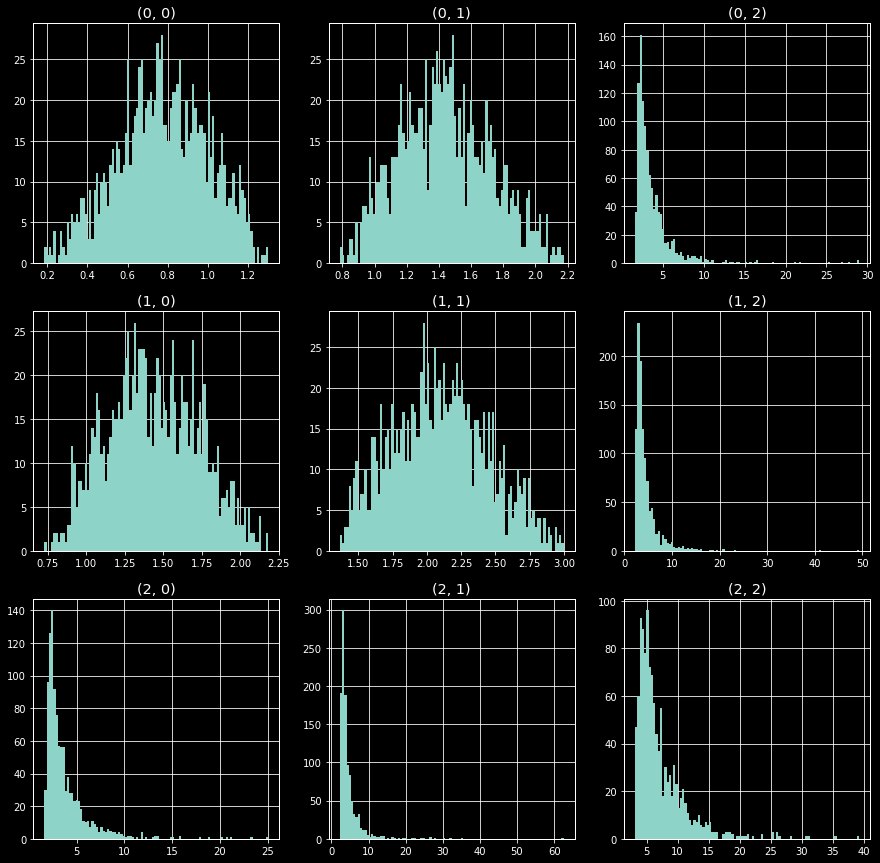

In [60]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.style.use(['dark_background'])

# this is matts style
N = 10000
data = np.random.normal(size = (N,2))

df = pd.DataFrame(data,columns = ['x1','x2'])
df['target'] = np.exp(df.x1) #+ np.exp(df.x2)
q = 3
# note I couldn't figure out how to get the bins retbins=True, figured I could index into the output but nope
# he actually doesnt make a df2 because he wants it to go away once the cell has run to avoid confusion
df = (df
       .assign(x1_quant = lambda x: pd.qcut(x.x1,q=q,labels=False))
       .assign(x2_quant = lambda x: pd.qcut(x.x2,q=q,labels=False))
       .groupby(['x1_quant','x2_quant'])
      )
# plot
fig, axes = plt.subplots(q,q,figsize=(15,15))

for g, group in df:
    # g is the combo of which labels are included in the group
    ax = axes[g]
    ax.hist(group['target'],bins=100)
    ax.set_title(g)

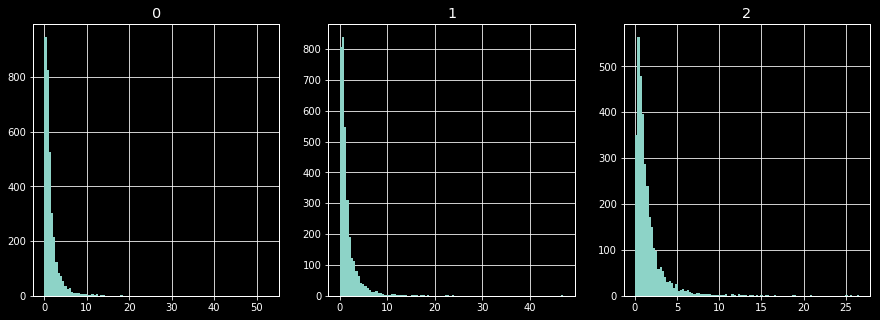

In [59]:
# this is matts style
N = 10000
data = np.random.normal(size = (N,2))

df = pd.DataFrame(data,columns = ['x1','x2'])
df['target'] = np.exp(df.x1) #+ np.exp(df.x2)
q = 3
# note I couldn't figure out how to get the bins retbins=True, figured I could index into the output but nope
# he actually doesnt make a df2 because he wants it to go away once the cell has run to avoid confusion
df = (df
#        .assign(x1_quant = lambda x: pd.qcut(x.x1,q=q,labels=False))
       .assign(x2_quant = lambda x: pd.qcut(x.x2,q=q,labels=False))
       .groupby(['x2_quant'])
      )
# plot
fig, axes = plt.subplots(1,q,figsize=(15,5))

for g, group in df:
    # g is the combo of which labels are included in the group
    ax = axes[g]
    ax.hist(group['target'],bins=100)
    ax.set_title(g)

In [22]:
q=5
bins = pd.qcut(df.x1,q=q,retbins=True,labels=False)[1]#,labels=range(q))
bins

array([-4.10063434, -0.83276999, -0.23537854,  0.24821562,  0.82860674,
        4.51772273])

In [12]:
bins

array([-3.71772753, -0.82335029, -0.23887522,  0.26702875,  0.86834813,
        3.65210289])

Interesting to show:

- show that a log normal is just a normal and back and forth
- show that y(x) ~ f(x) (where x is a vector) could have different spreads if you include more or less in x
- Mixture of distributions (linear combo of gaussian and log normal)

Check this with Matt or internet

- If the model is biased (say its quadratic when the underlying data is linear), its estimate of the mean and variance at each of those points in the feature space will have high bias (and thus won't be good estimators of the distributions at those points)
- he said something about high variance 

**Properties of a random variable (this is an attempt)**

- pdf (parameterized if special class), cdf (can be determined from pdf), survival curve (something like 1 - cdf)
- are these part of probability theory? Where does stats begin and prob theory end

In [12]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.style.use(['dark_background'])

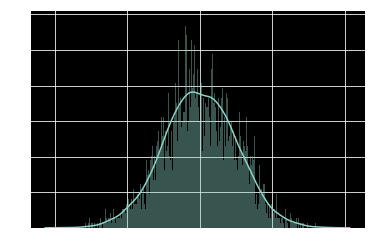

In [22]:
N = 10000
x_n = np.random.normal(size = N)
sns.distplot(x_n, bins = int(N/10))
plt.show()

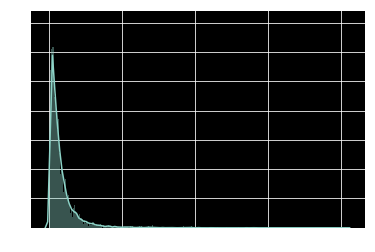

In [23]:
N = 10000
x_ln = np.random.lognormal(size = N)
sns.distplot(x_ln, bins = int(N/10))
plt.show()

Pareto distribution (this function actually centers it at 0 instead of 1 https://numpy.org/doc/stable/reference/random/generated/numpy.random.pareto.html)

https://www.statisticshowto.com/pareto-principle-the-8020-rule/

https://www.statisticshowto.com/pareto-distribution/

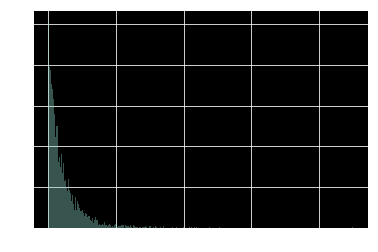

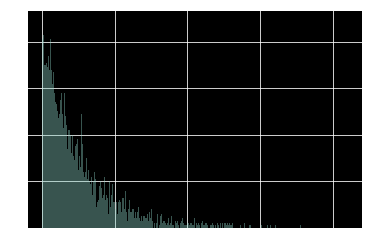

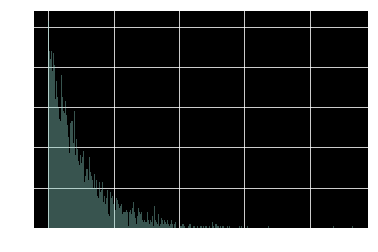

In [33]:
N = 10000
alphas = [10,100,1000]
for alpha in alphas:
    x_p = np.random.pareto(alpha,size = 10000) + 1
    sns.distplot(x_p, bins = int(N/10), kde=False)
    plt.show()